# Multi-Class SVM

- Build the general architecture of a multi-class SVM, including:
    - Calculating the cost function and its gradient
    - Find the optimal hyperparameters by cross validation

# Load Required Libraries

In [1]:
import random
import numpy as np
from past.builtins import xrange
from local_utils.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
import time

## CIFAR-10 load data

Next cell defines a data helper function that does some basic preprocessing.

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = '../../data/cifar/'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Task 1: Multi-Class SVM - Loss Function and Gradient

In [3]:
def svm_loss_naive(W, X, y, reg):
    """
    Structured SVM loss function, naive implementation (with loops).

    Inputs have dimension D, there are C classes, and we operate on minibatches
    of N examples.

    Inputs:
    - W: A numpy array of shape (D, C) containing weights.
    - X: A numpy array of shape (N, D) containing a minibatch of data.
    - y: A numpy array of shape (N,) containing training labels; y[i] = c means
         that X[i] has label c, where 0 <= c < C.
    - reg: (float) regularization strength

    Returns a tuple of:
    - loss as single float
    - gradient with respect to weights W; an array of same shape as W
    """
    dW = np.zeros(W.shape) # initialize the gradient as zero
    num_classes = W.shape[1]
    num_samples = X.shape[0]

    #############################################################################
    # TODO: Compute the multi-class svm loss and its gradient using explicit    #
    # loops. Store the loss in loss and the gradient in dW. Don't forget the    #
    # regularization!                                                           #
    #############################################################################
    
    # we assume that delta = 1 (i.e. the distance parameter of hinge loss is 1, which is the default value in the field)
    loss = 0.0
    for i in xrange(num_samples):
        raw_scores = X[i, :].dot(W)
        correct_class_score = raw_scores[y[i]]
        for j in xrange(num_classes):
            if j == y[i]:
                continue # do nothing if currently looking at the true class, b.c. we only calculate the distance to other classes
            margin = raw_scores[j] - correct_class_score + 1
            if margin > 0:
                loss += margin
                dW[:, j] += X[i, :]#.T
                dW[:, y[i]] -= X[i, :]#.T

    # Right now the loss is a sum over all training examples, but we want it
    # to be an average instead so we divide by num_train.
    loss /= num_samples
    dW   /= num_samples

    # Add regularization to the loss.
    loss += 0.5 * reg * np.sum(W * W)
    dW   += reg * W

   
    
    #############################################################################
    #                         END OF YOUR CODE                                  #
    #############################################################################
    return loss, dW

# Task 2: Multi-Class SVM

In [5]:
def svm_loss_vectorized(W, X, y, reg):
    """
    Structured SVM loss function, vectorized implementation.

    Inputs and outputs are the same as svm_loss_naive.
    """
    loss = 0.0
    dW = np.zeros(W.shape) # initialize the gradient as zero

    #############################################################################
    # TODO:                                                                     #
    # Implement a vectorized version of the structured SVM loss, storing the    #
    # result in loss.                                                           #
    #############################################################################
    num_samples = X.shape[0]
    raw_scores = X.dot(W) # calculate the raw scores by dot product
    idxs = np.array(range(num_samples)) # this idxs variable is needed for correctly subsetting numpy array
    correct_class_scores = raw_scores[idxs, y] # select the scores of the correct class lables 
    correct_class_scores.shape = (num_samples, 1) # reshape (500, ) to (500, 1) array
    
    
    difference = np.maximum(0, raw_scores - correct_class_scores + 1)
    difference [idxs, y] = 0
    loss = np.sum(difference) # calculate the total loss, by summing up all differences between scores for every trainset example

    loss /= num_samples
    loss += 0.5 * reg * np.sum(W * W)
    
    
    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################


    #############################################################################
    # TODO:                                                                     #
    # Implement a vectorized version of the gradient for the structured SVM     #
    # loss, storing the result in dW.                                           #
    #                                                                           #
    # Hint: Instead of computing the gradient from scratch, it may be easier    #
    # to reuse some of the intermediate values that you used to compute the     #
    # loss.                                                                     #
    #############################################################################
    
    difference = np.where(difference > 0, 1, 0) # Those where difference > 0, set to 1. Those where difference < 0, set to 0 
    difference[np.arange(0, raw_scores.shape[0]), y] = -1 * np.sum(difference, 1)
    dW = np.dot(X.T, difference)

    dW /= num_samples
    dW += reg * W
    
    
    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################

    return loss, dW

# Check: Performance

Execute the cell below to run a performance comparison between the naive implementation using loops
and the optimized version using vectorized instructions.
The two versions should compute the same results, but the vectorized version should be much faster.

In [6]:
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
diff = tic - toc
print('Naive loss: %e computed in %fs' % (loss_naive, diff))

tic = time.time()
loss_vectorized, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
diff_vec = tic - toc
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, diff_vec))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)
print('Runtime abs. difference: %f seconds' % (diff_vec - diff))
print('Runtime rel. improvement: %f percent' % (1 - (diff_vec / diff)))

Naive loss: 8.923784e+00 computed in -0.104689s
Vectorized loss: 8.923784e+00 computed in 0.000000s
Loss difference: 0.000000
Gradient difference: 0.000000
Runtime abs. difference: 0.104689 seconds
Runtime rel. improvement: 1.000000 percent


# Stochastic Gradient Descent

In [7]:
# train multi-class svm by SGD, implemented in last assignment
def train_SGD(X, y, learning_rate=1e-3, reg=1e-5, num_iters=100,
            batch_size=200, verbose=False):
    """
    Train this linear classifier using stochastic gradient descent.

    Inputs:
    - X: A numpy array of shape (N, D) containing training data; there are N
      training samples each of dimension D.
    - y: A numpy array of shape (N,) containing training labels; y[i] = c
      means that X[i] has label 0 <= c < C for C classes.
    - learning_rate: (float) learning rate for optimization.
    - reg: (float) regularization strength.
    - num_iters: (integer) number of steps to take when optimizing
    - batch_size: (integer) number of training examples to use at each step.
    - verbose: (boolean) If true, print progress during optimization.

    Outputs:
    W: A numpy array of shape (D, C) containing weights
    loss_history: A list containing the value of the loss function at each training iteration.
    """
    num_train, dim = X.shape
    num_classes = np.max(y) + 1 # assume y takes values 0...K-1 where K is number of classes
   
    # Generate a random softmax weight matrix
    W = 0.001 * np.random.randn(dim, num_classes)

    # Run stochastic gradient descent to optimize W
    loss_history = []
    for it in xrange(num_iters):
        X_batch = None
        y_batch = None
        p = np.random.choice(num_train, batch_size)
        X_batch = X[p,:]
        y_batch = y[p]
  

        # evaluate loss and gradient
        loss, grad = svm_loss_vectorized(W,X_batch, y_batch, reg)
        loss_history.append(loss)
 
        W -= learning_rate*grad

        if verbose and it % 100 == 0:
            print('iteration %d / %d: loss %f' % (it, num_iters, loss))

    return W, loss_history

# SVM Training

In [8]:
tic = time.time()
W, loss_hist = train_SGD(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('This took %fs' % (toc - tic))

iteration 0 / 1500: loss 406.725973
iteration 100 / 1500: loss 239.852995
iteration 200 / 1500: loss 145.588489
iteration 300 / 1500: loss 90.000083
iteration 400 / 1500: loss 55.475847
iteration 500 / 1500: loss 35.490536
iteration 600 / 1500: loss 22.707526
iteration 700 / 1500: loss 15.442184
iteration 800 / 1500: loss 11.517293
iteration 900 / 1500: loss 9.254925
iteration 1000 / 1500: loss 7.921169
iteration 1100 / 1500: loss 6.475709
iteration 1200 / 1500: loss 5.869633
iteration 1300 / 1500: loss 5.933665
iteration 1400 / 1500: loss 5.181684
This took 7.491635s


# Check: Prediction

In [9]:
def predict(W, X):
    """
    Use the trained weights of this linear classifier to predict labels for
    data points.

    Inputs:
    - W: A numpy array of shape (D, C) containing weights
    - X: A numpy array of shape (N, D) containing training data; there are N
      training samples each of dimension D.

    Returns:
    - y_pred: Predicted labels for the data in X. y_pred is a 1-dimensional
      array of length N, and each element is an integer giving the predicted
      class.
    """
    y_pred = np.zeros(X.shape[0])
    y_pred = np.argmax(np.dot(X,W),axis=1)
    return y_pred

In [26]:
# Write the predict function and evaluate the performance on both the
# training and validation set
y_train_pred = predict(W,X_train)
print('training accuracy: %f' % np.mean(y_train == y_train_pred))
y_val_pred = predict(W,X_val)
print('validation accuracy: %f' % np.mean(y_val == y_val_pred))

training accuracy: 0.381367
validation accuracy: 0.403000


# Task 3: Hyperparameter

In [33]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
learning_rates = [1e-7, 5e-8, 1e-8]
regularization_strengths = [2.5e4, 5e4]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_W = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
for lr in learning_rates:
    for reg in regularization_strengths:
        
        # train the matrix W
        W, _  = train_SGD(X_train, y_train, learning_rate=lr, reg=reg, num_iters=1500, verbose=True)
        
        # predict values using the trained matrix W
        y_train_pred = predict(W, X_train)
        y_val_pred = predict(W, X_val)
        
        # compute accuracies
        train_accuracy = np.mean(y_train == y_train_pred) # train accuracy
        val_accuracy = np.mean(y_val == y_val_pred) # validation set accuracy
        
        results[lr, reg] = train_accuracy, val_accuracy
        
        if val_accuracy > best_val:
            best_val = val_accuracy
            best_W = W
        
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1500: loss 409.187282
iteration 100 / 1500: loss 241.592105
iteration 200 / 1500: loss 147.126036
iteration 300 / 1500: loss 90.179370
iteration 400 / 1500: loss 56.556045
iteration 500 / 1500: loss 35.997781
iteration 600 / 1500: loss 24.050751
iteration 700 / 1500: loss 16.617119
iteration 800 / 1500: loss 11.702905
iteration 900 / 1500: loss 9.348295
iteration 1000 / 1500: loss 6.595140
iteration 1100 / 1500: loss 5.931898
iteration 1200 / 1500: loss 5.836534
iteration 1300 / 1500: loss 5.736976
iteration 1400 / 1500: loss 5.141270
iteration 0 / 1500: loss 797.894937
iteration 100 / 1500: loss 290.737954
iteration 200 / 1500: loss 109.313708
iteration 300 / 1500: loss 43.728675
iteration 400 / 1500: loss 18.910334
iteration 500 / 1500: loss 10.288576
iteration 600 / 1500: loss 7.247003
iteration 700 / 1500: loss 6.059927
iteration 800 / 1500: loss 5.443085
iteration 900 / 1500: loss 5.036185
iteration 1000 / 1500: loss 5.981906
iteration 1100 / 1500: loss 5.467326
iter

# Check: Test Accuracy and Weight Visualization
Here we test the SVM implementation on unseen test data. Accuracy should be around 0.35.
The last cell displays the (rescaled) weights that our SVM has learned for each class.

In [34]:
# Evaluate the best svm on test set
y_test_pred = predict(best_W,X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.360000


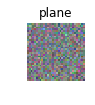

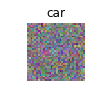

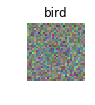

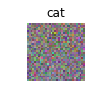

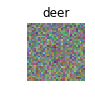

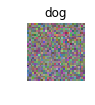

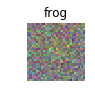

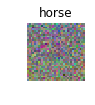

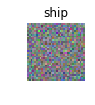

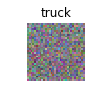

In [52]:
# Visualize the learned weights for each class.
# Depending on the choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])
    plt.show()